In [54]:
import rlcard
from rlcard.agents import DQNAgent
from rlcard.utils import set_seed, tournament
import numpy as np
import torch
import optuna
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


In [46]:
set_seed(24)

env = rlcard.make("blackjack")
eval_env = rlcard.make("blackjack")

print("Number of actions:", env.num_actions)
print("Number of players:", env.num_players)
print("Shape of state:", env.state_shape)
print("Shape of action:", env.action_shape)

Number of actions: 2
Number of players: 1
Shape of state: [[2]]
Shape of action: [None]


In [47]:
def objective(trial):
    """
    Objective function for Optuna optimization
    """
    # Create fresh environments for each trial
    env = rlcard.make("blackjack")
    eval_env = rlcard.make("blackjack")
    
    # Set seed for reproducibility within trial
    set_seed(trial.number + 42)
    
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    epsilon_decay_steps = trial.suggest_int('epsilon_decay_steps', 3000, 25000)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    
    # Network architecture
    network_choice = trial.suggest_categorical('network_choice', [
        'small', 'medium', 'large', 'deep'
    ])
    
    network_configs = {
        'small': [64, 64],
        'medium': [128, 128], 
        'large': [256, 128],
        'deep': [64, 128, 64]
    }
    mlp_layers = network_configs[network_choice]
    
    # Additional hyperparameters
    replay_memory_size = trial.suggest_categorical('replay_memory_size', [10000, 20000, 50000])
    train_every = trial.suggest_int('train_every', 1, 4)
    
    # Create DQN agent with suggested parameters
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    try:
        agent = DQNAgent(
            num_actions=env.num_actions,
            state_shape=env.state_shape[0],
            mlp_layers=mlp_layers,
            learning_rate=learning_rate,
            epsilon_decay_steps=epsilon_decay_steps,
            batch_size=batch_size,
            replay_memory_size=replay_memory_size,
            replay_memory_init_size=max(batch_size * 3, 1000),  # Ensure enough initial experiences
            train_every=train_every,
            device=device,
        )
    except Exception as e:
        print(f"Error creating agent: {e}")
        return -1.0  # Return bad score for invalid configs
    
    # Training parameters
    num_episodes = 4000  # Reduced for faster trials
    eval_freq = 1000
    eval_games = 500
    
    best_performance = -float('inf')
    
    print(f"Trial {trial.number}: LR={learning_rate:.1e}, "
          f"EPS_DECAY={epsilon_decay_steps}, BATCH={batch_size}, "
          f"NET={network_choice}")
    
    # Training loop
    for episode in range(num_episodes):
        # Training step
        state, player_id = env.reset()
        
        while not env.is_over():
            action = agent.step(state)
            next_state, next_player_id = env.step(action)
            
            if env.is_over():
                payoffs = env.get_payoffs()
                reward = payoffs[0]
                done = True
            else:
                reward = 0
                done = False
            
            agent.feed((state, action, reward, next_state, done))
            state = next_state
            player_id = next_player_id
        
        # Evaluation
        if episode % eval_freq == 0:
            eval_rewards = []
            for _ in range(eval_games):
                eval_state, eval_player_id = eval_env.reset()
                
                while not eval_env.is_over():
                    action, _ = agent.eval_step(eval_state)
                    eval_state, eval_player_id = eval_env.step(action)
                
                payoffs = eval_env.get_payoffs()
                eval_rewards.append(payoffs[0])
            
            avg_reward = np.mean(eval_rewards)
            
            if avg_reward > best_performance:
                best_performance = avg_reward
            
            print(f"  Episode {episode}: {avg_reward:.3f} (best: {best_performance:.3f})")
            
            # Report intermediate value to Optuna for pruning
            trial.report(avg_reward, episode)
            
            # Handle pruning based on the intermediate value
            if trial.should_prune():
                print(f"  Trial {trial.number} pruned at episode {episode}")
                raise optuna.exceptions.TrialPruned()
    
    print(f"Trial {trial.number} completed with best performance: {best_performance:.3f}")
    return best_performance

print("✅ Objective function defined!")


✅ Objective function defined!


In [48]:
# Create study with pruning for efficiency
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=2000,
        interval_steps=1000
    )
)

print("✅ Optuna study created with median pruning!")
print("Study configuration:")
print(f"  Direction: {study.direction}")
print(f"  Pruner: {type(study.pruner).__name__}")

[I 2025-06-23 03:00:12,196] A new study created in memory with name: no-name-89d2657a-57c8-4561-af36-e0845a8a1876


✅ Optuna study created with median pruning!
Study configuration:
  Direction: 2
  Pruner: MedianPruner


In [ ]:
N_TRIALS = 20

try:
    study.optimize(objective, n_trials=N_TRIALS, timeout=7200)  # 2 hour timeout
except KeyboardInterrupt:
    print("\n⏹️ Optimization interrupted by user")

print(f"End time: {datetime.now().strftime('%H:%M:%S')}")
print("✅ Optimization completed!")

# Cell 6: Display Results
print("\n" + "=" * 60)
print("🏆 OPTIMIZATION RESULTS")
print("=" * 60)

print(f"Number of finished trials: {len(study.trials)}")
print(f"Number of pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"Number of complete trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")

if study.best_trial:
    print(f"\n🥇 Best trial: {study.best_trial.number}")
    print(f"🎯 Best performance: {study.best_value:.4f}")
    print("\n🔧 Best parameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
else:
    print("❌ No best trial found")

# Cell 7: Analyze Results and Create Visualizations
# Get completed trials
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

if complete_trials:
    # Create DataFrame for analysis
    data = []
    for trial in complete_trials:
        row = trial.params.copy()
        row['performance'] = trial.value
        row['trial_number'] = trial.number
        data.append(row)
    
    df = pd.DataFrame(data)
    
    print("\n📊 Performance Statistics:")
    print(f"  Mean: {df['performance'].mean():.4f}")
    print(f"  Std:  {df['performance'].std():.4f}")
    print(f"  Min:  {df['performance'].min():.4f}")
    print(f"  Max:  {df['performance'].max():.4f}")
    
    # Parameter importance (if enough trials)
    if len(complete_trials) >= 10:
        try:
            importance = optuna.importance.get_param_importances(study)
            print(f"\n🎯 Parameter Importance:")
            for param, imp in sorted(importance.items(), key=lambda x: x[1], reverse=True):
                print(f"  {param}: {imp:.3f}")
        except:
            print("\n⚠️ Could not calculate parameter importance")
    
    print(f"\n✅ Results stored in DataFrame 'df' with {len(df)} trials")
else:
    print("❌ No completed trials to analyze")

In [ ]:
# Get completed trials
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

if complete_trials:
    # Create DataFrame for analysis
    data = []
    for trial in complete_trials:
        row = trial.params.copy()
        row['performance'] = trial.value
        row['trial_number'] = trial.number
        data.append(row)
    
    df = pd.DataFrame(data)
    
    print("\n📊 Performance Statistics:")
    print(f"  Mean: {df['performance'].mean():.4f}")
    print(f"  Std:  {df['performance'].std():.4f}")
    print(f"  Min:  {df['performance'].min():.4f}")
    print(f"  Max:  {df['performance'].max():.4f}")
    
    # Parameter importance (if enough trials)
    if len(complete_trials) >= 10:
        try:
            importance = optuna.importance.get_param_importances(study)
            print(f"\n🎯 Parameter Importance:")
            for param, imp in sorted(importance.items(), key=lambda x: x[1], reverse=True):
                print(f"  {param}: {imp:.3f}")
        except:
            print("\n⚠️ Could not calculate parameter importance")
    
    print(f"\n✅ Results stored in DataFrame 'df' with {len(df)} trials")
else:
    print("❌ No completed trials to analyze")

In [ ]:
if study.best_params:
    print("\n" + "=" * 60)
    print("🧪 TRAINING FINAL MODEL WITH BEST PARAMETERS")
    print("=" * 60)
    
    # Extract best parameters
    params = study.best_params
    network_configs = {
        'small': [64, 64],
        'medium': [128, 128], 
        'large': [256, 128],
        'deep': [64, 128, 64]
    }
    
    print("Best configuration:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    # Create final agent
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    final_agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=network_configs[params['network_choice']],
        learning_rate=params['learning_rate'],
        epsilon_decay_steps=params['epsilon_decay_steps'],
        batch_size=params['batch_size'],
        replay_memory_size=params.get('replay_memory_size', 20000),
        replay_memory_init_size=max(params['batch_size'] * 3, 1000),  # Fix for final agent too
        train_every=params.get('train_every', 1),
        device=device
    )
    
    print("\n🚀 Starting extended training with best parameters...")
    
    # Extended training with periodic evaluation
    training_history = []
    
    for episode in range(10000):  # Longer training
        state, player_id = env.reset()
        
        while not env.is_over():
            action = final_agent.step(state)
            next_state, next_player_id = env.step(action)
            
            if env.is_over():
                payoffs = env.get_payoffs()
                reward = payoffs[0]
                done = True
            else:
                reward = 0
                done = False
            
            final_agent.feed((state, action, reward, next_state, done))
            state = next_state
            player_id = next_player_id
        
        # Evaluate every 2000 episodes
        if episode % 2000 == 0:
            eval_rewards = []
            for _ in range(1000):
                eval_state, eval_player_id = eval_env.reset()
                
                while not eval_env.is_over():
                    action, _ = final_agent.eval_step(eval_state)
                    eval_state, eval_player_id = eval_env.step(action)
                
                payoffs = eval_env.get_payoffs()
                eval_rewards.append(payoffs[0])
            
            avg_reward = np.mean(eval_rewards)
            win_rate = (np.array(eval_rewards) > 0).mean()
            training_history.append((episode, avg_reward, win_rate))
            
            print(f"Episode {episode:5d}: Reward = {avg_reward:6.4f}, Win Rate = {win_rate:.3f}")
    
    print("\n✅ Extended training completed!")
    
    # Final evaluation
    print("\n📊 Final Performance Assessment:")
    final_rewards = []
    for _ in range(2000):  # More games for better estimate
        eval_state, eval_player_id = eval_env.reset()
        
        while not eval_env.is_over():
            action, _ = final_agent.eval_step(eval_state)
            eval_state, eval_player_id = eval_env.step(action)
        
        payoffs = eval_env.get_payoffs()
        final_rewards.append(payoffs[0])
    
    final_avg = np.mean(final_rewards)
    final_win_rate = (np.array(final_rewards) > 0).mean()
    final_std = np.std(final_rewards)
    
    print(f"Final Average Reward: {final_avg:.4f} ± {final_std:.4f}")
    print(f"Final Win Rate: {final_win_rate:.3f}")
    print(f"Games Won: {int(final_win_rate * 2000)}/2000")

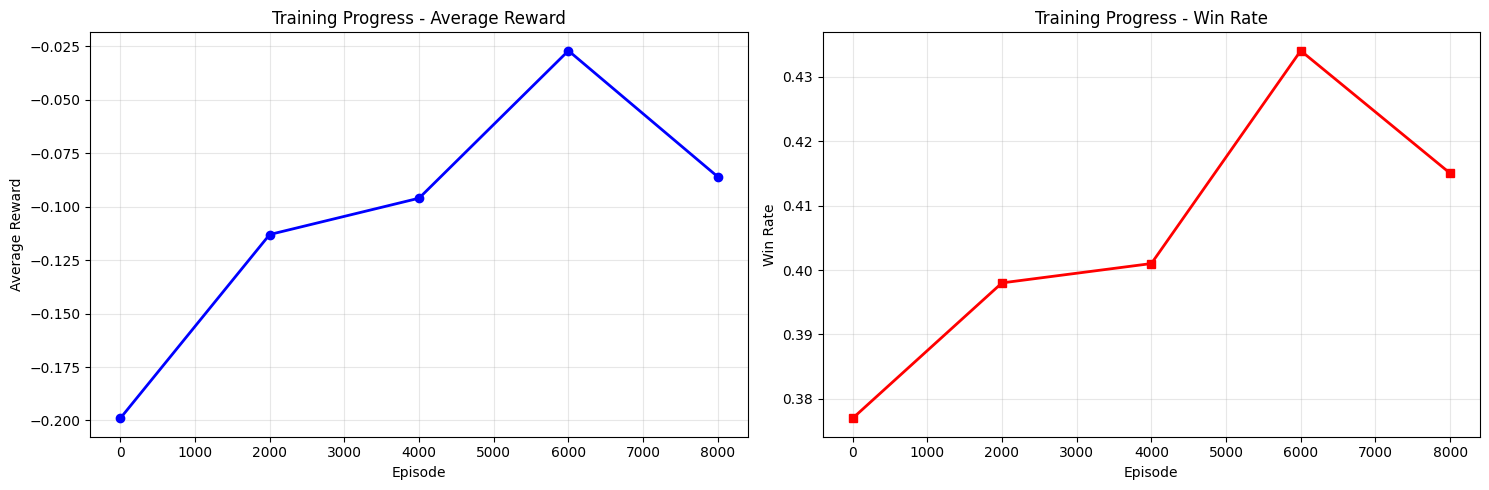

📈 Training progress plotted!

🎉 Hyperparameter tuning complete!
You can now use the optimized agent for your blackjack games!


In [53]:
if 'training_history' in locals() and training_history:
    episodes, rewards, win_rates = zip(*training_history)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot average rewards
    ax1.plot(episodes, rewards, 'b-', linewidth=2, marker='o')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Average Reward')
    ax1.set_title('Training Progress - Average Reward')
    ax1.grid(True, alpha=0.3)
    
    # Plot win rates
    ax2.plot(episodes, win_rates, 'r-', linewidth=2, marker='s')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Win Rate')
    ax2.set_title('Training Progress - Win Rate')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📈 Training progress plotted!")

print("\n🎉 Hyperparameter tuning complete!")
print("You can now use the optimized agent for your blackjack games!")